# Playing with DNB data

Today, we will be working with a public data set and a public data set that is published by DNB. We will use this Jupyter notebook to work with both code and rich text elements, such as figures, links, equations, ... Because of the mix of code and text elements, these documents are the ideal place to bring together an analysis description and its results as well as they can be executed perform the data analysis in real time.

You will have to fill in the blanks at some points, run the code at others. You are free to change code or experiment. Make sure to ask us for help if you cannot come up with the solution or get stuck somewhere!

---

Some things you should know about the Jupyter notebook:

Each block that you navigate using the up and down keys is called a cell
* Hit [Shift+Enter] to execute a cell
* Hit [Enter] to edit a cell in the Edit mode. Once you are done, hit [Escape] to come back into command mode
* For a list of all shortcuts, when in command mode, hit [Ctrl+H]

Try running the cell below using the methods suggested above. You can edit the text if you like.

In [ ]:
print('Hello World')

---

## Let's get started

Great, now we're ready to start. First, we need some libraries that we use throughout this notebook. These libraries range from data analysis libraries such as Pandas to plotting libraries such as matplotlib. 

In [132]:
import pandas as pd
import numpy as np
from load_solvency import read_sheet
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fast')
plt.rcParams['figure.figsize'] = [12, 12]
from sklearn.manifold import TSNE



from fbprophet import Prophet

## Read in the data

Before moving on to analysis, we need to load the data first from the internet and shape it into the right format. Let's read in data on the Euribor, the Euro Interbank Offer Rate*. We will first define the url that points to the data that we need and then use it to read the data into a Pandas dataframe.

In [11]:
url = 'https://www.emmi-benchmarks.eu/assets/modules/rateisblue/file_processing/publication/processed/hist_EURIBOR_2018.csv' 

In [12]:
euribor = pd.read_csv(url, index_col=[0])

Let's take a look at the first 10 rows.

In [13]:
euribor.head(10)

,02/01/2018,03/01/2018,04/01/2018,05/01/2018,08/01/2018,09/01/2018,10/01/2018,11/01/2018,12/01/2018,15/01/2018,...,14/12/2018,17/12/2018,18/12/2018,19/12/2018,20/12/2018,21/12/2018,24/12/2018,27/12/2018,28/12/2018,31/12/2018
1w,-0.379,-0.379,-0.378,-0.379,-0.379,-0.379,-0.379,-0.379,-0.379,-0.379,...,-0.378,-0.378,-0.378,-0.378,-0.379,-0.376,-0.375,-0.374,-0.373,-0.373
2w,-0.373,-0.374,-0.371,-0.374,-0.374,-0.375,-0.374,-0.374,-0.373,-0.373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1m,-0.368,-0.368,-0.368,-0.369,-0.368,-0.369,-0.369,-0.369,-0.369,-0.369,...,-0.368,-0.369,-0.369,-0.369,-0.367,-0.366,-0.365,-0.364,-0.364,-0.363
2m,-0.340,-0.341,-0.339,-0.340,-0.341,-0.341,-0.341,-0.341,-0.341,-0.341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3m,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,...,-0.311,-0.311,-0.311,-0.309,-0.310,-0.310,-0.309,-0.309,-0.310,-0.309
6m,-0.271,-0.271,-0.271,-0.271,-0.271,-0.271,-0.271,-0.271,-0.271,-0.274,...,-0.238,-0.237,-0.238,-0.238,-0.238,-0.238,-0.237,-0.237,-0.236,-0.237
9m,-0.217,-0.219,-0.220,-0.219,-0.220,-0.219,-0.220,-0.217,-0.216,-0.221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12m,-0.186,-0.187,-0.187,-0.187,-0.187,-0.187,-0.186,-0.188,-0.186,-0.187,...,-0.128,-0.127,-0.125,-0.124,-0.121,-0.119,-0.118,-0.119,-0.119,-0.117


Personally, I think it makes more sense to transpose the dataframe. 

In [14]:
euribor = euribor.T

In [15]:
euribor.head(3)

,1w,2w,1m,2m,3m,6m,9m,12m
02/01/2018,-0.379,-0.373,-0.368,-0.340,-0.329,-0.271,-0.217,-0.186
03/01/2018,-0.379,-0.374,-0.368,-0.341,-0.329,-0.271,-0.219,-0.187
04/01/2018,-0.378,-0.371,-0.368,-0.339,-0.329,-0.271,-0.220,-0.187


There is a convenient function called ``describe()`` that automatically calculates some basic statistics on the ``euribor`` data set.

Usually, date columns are not parsed automatically, so we need to tell pandas to store the index column in date format. 

In [16]:
euribor.index = pd.to_datetime(euribor.index, dayfirst=True)

In [17]:
euribor.describe()

,1w,2w,1m,2m,3m,6m,9m,12m
count,255.000000,236.000000,255.000000,236.000000,255.000000,255.000000,236.000000,255.000000
mean,-0.377871,-0.372686,-0.369804,-0.338894,-0.322086,-0.266384,-0.213305,-0.173024
std,0.001494,0.002415,0.001442,0.001889,0.005400,0.008891,0.008337,0.019428
min,-0.381000,-0.379000,-0.372000,-0.342000,-0.329000,-0.279000,-0.224000,-0.193000
25%,-0.379000,-0.374000,-0.371000,-0.341000,-0.328000,-0.271000,-0.220000,-0.189000
50%,-0.378000,-0.372000,-0.370000,-0.339000,-0.321000,-0.269000,-0.216000,-0.181000
75%,-0.377000,-0.371000,-0.369000,-0.337000,-0.318000,-0.266000,-0.207000,-0.159000
max,-0.373000,-0.369000,-0.363000,-0.336000,-0.309000,-0.236000,-0.194000,-0.117000


## Visualize the data

Let's take a visual look at the data.

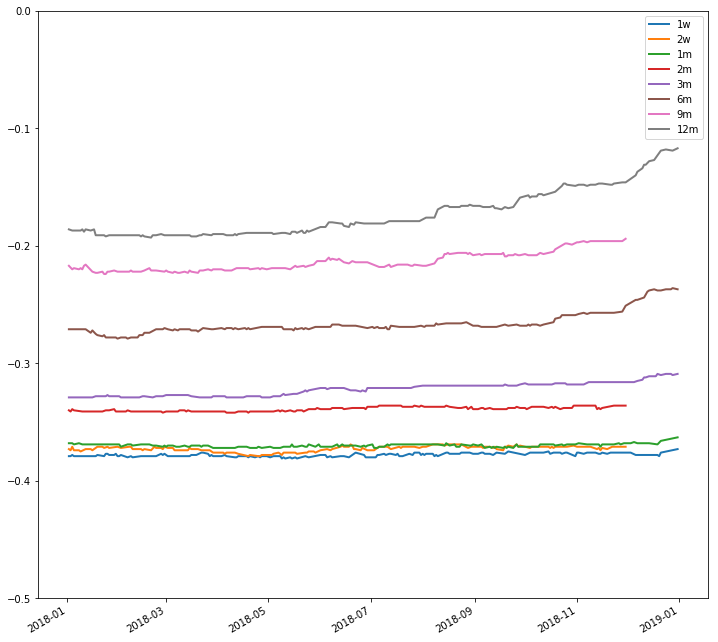

In [78]:
euribor.plot(ylim=[-0.5,0], lw=2)

## Predict the future benchmark rate

Maybe we would want to forecast how one of the benchmark rates will move in the future. One well-known way of doing this, would be using an [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) to do 'time series forecasting'. Another way that we will use here is a forecasting method that was developed by Facebook called [Prophet](https://facebook.github.io/prophet/), which they use in production. Be sure to read their paper if you are interested to find out the technical details. In this notebook, you will see how easy it is to use the model.

Say we would like to know what the 1 year euribor will do in the future based on the data we have just loaded in. We first need to get the data in the right format for Prophet to be able to use the data: it expects a Dataframe with one column `ds` and one column `y`, for the dates and rates respectively. 

In [19]:
df = euribor['12m'].reset_index() # to convert the index column to a 'regular' column
df.columns = ['ds', 'y']

In [20]:
df.head(5)

,ds,y
0,2018-01-02,-0.186
1,2018-01-03,-0.187
2,2018-01-04,-0.187
3,2018-01-05,-0.187
4,2018-01-08,-0.187


We can now initialize the model and fit it to our prepared data set `df`.

In [21]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The model is now trained on our data. Let's create a dataframe 180 days in the future to predict the future rate.

In [22]:
future = m.make_future_dataframe(periods=180)
future.tail()

,ds
430,2019-06-25
431,2019-06-26
432,2019-06-27
433,2019-06-28
434,2019-06-29


Let's predict.

In [23]:
forecast = m.predict(future)
forecast[['ds', 'yhat']].tail()


,ds,yhat
430,2019-06-25,-0.049369
431,2019-06-26,-0.048870
432,2019-06-27,-0.048360
433,2019-06-28,-0.047888
434,2019-06-29,-0.046263


And plot our prediction.

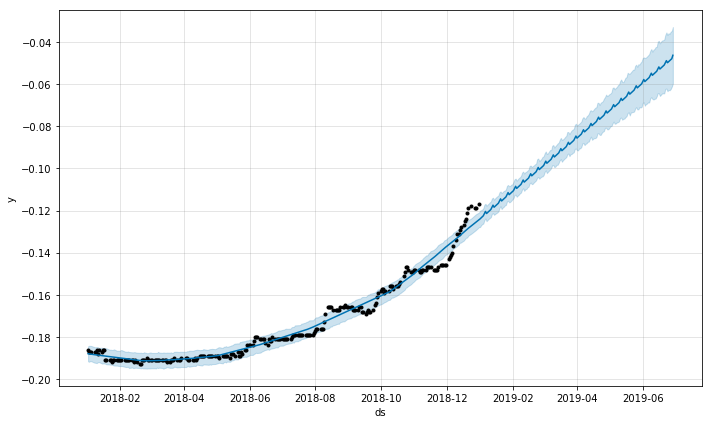

In [24]:
m.plot(forecast)
plt.show()

---

## Your turn: Solvency II data

Up and till now, you have been able to sit back and [Shift-Enter]. Now - if you have time left... - try and reuse parts of what you learned in this section to complete the exercises below. This time you'll be using a public data set published on DNB's website.

Let's start by reading in a new data set. The name of the data file is `Individuele gegevens verzekeraars per jaar.xlsx`. It contains information from https://statistiek.dnb.nl/downloads/index.aspx#/details/individuele-gegevens-verzekeraars-jaar/dataset/d66feb58-e89b-4c73-b0c7-cab81188ca77 and contains public information about insurance companies. More specifically, we use public Solvency II data from individual Dutch insurance undertakings./ 

We will walk through similar steps as before, but now, you will need to actually write some code and fill code cells to analyze the data. If you get stuck, scroll up to the relevant code you ran earlier.

Let's start by reading in the data using the name given above. 

**Exercise**: Edit line 1 such that you load in the correct file. Keep line 2 as is.

In [25]:
xls = pd.ExcelFile('Individuele gegevens verzekeraars per jaar.xlsx')
df = read_sheet(14, xls)

**Exercise:** Take a peak at the data in `df` using the `head` function.

In [26]:
df.head(3)

intangible assets  \
relatienaam                     periode                         
ABN AMRO Captive N.V.           2016-12-31                0.0   
                                2017-12-31                0.0   
ABN AMRO Levensverzekering N.V. 2016-12-31                0.0   

                                            deferred tax assets  \
relatienaam                     periode                           
ABN AMRO Captive N.V.           2016-12-31            263571.75   
                                2017-12-31            176064.65   
ABN AMRO Levensverzekering N.V. 2016-12-31                 0.00   

                                            pension benefit surplus  \
relatienaam                     periode                               
ABN AMRO Captive N.V.           2016-12-31                      0.0   
                                2017-12-31                      0.0   
ABN AMRO Levensverzekering N.V. 2016-12-31                      0.0   

                                            property, plant & equipment held for own use  \
relatienaam                     periode                                                    
ABN AMRO Captive N.V.           2016-12-31                                           0.0   
                                2017-12-31                                           0.0   
ABN AMRO Levensverzekering N.V. 2016-12-31                                           0.0   

                                            investments (other than assets held for index-linked and unit-linked contracts)  \
relatienaam                     periode                                                                                       
ABN AMRO Captive N.V.           2016-12-31                                       3.806327e+07                                 
                                2017-12-31                                       3.427627e+07                                 
ABN AMRO Levensverzekering N.V. 2016-12-31                                       1.216868e+09                                 

                                            investments (other than assets held for index-linked and unit-linked contracts)|property (other than for own use)  \
relatienaam                     periode                                                                                                                         
ABN AMRO Captive N.V.           2016-12-31                                                0.0                                                                   
                                2017-12-31                                                0.0                                                                   
ABN AMRO Levensverzekering N.V. 2016-12-31                                                0.0                                                                   

                                            investments (other than assets held for index-linked and unit-linked contracts)|holdings in related undertakings, including participations  \
relatienaam                     periode                                                                                                                                                  
ABN AMRO Captive N.V.           2016-12-31                                                0.0                                                                                            
                                2017-12-31                                                0.0                                                                                            
ABN AMRO Levensverzekering N.V. 2016-12-31                                                0.0                                                                                            

                                            investments (other than assets held for index-linked and unit-linked contracts)|equities  \
relatienaam                     periode                 

The data frame `df` now contains the data of the balance sheets of all Dutch insurance undertakings. Because Solvency II came into force in 2016 we have two years of data (per 2016-12-31 and per 2017-12-31).

Suppose we want to do some calculations with the balance sheets per 2017-12-31. 

Then we have to select this date from the data frame. For this we use the command `xs` of the `df` object. The parameters are `axis = 0` (we select from the rows), `level = 1` (level 0 is the name of the insurance undertaking and level 1 is the date of the report).

In [27]:
df = df.xs(datetime(2017,12,31), axis = 0, level = 1)

Let's see the number of insurance companies of which we have the balance sheet and how many columns of information we have:

In [28]:
nr_of_i = len(df)
nr_of_cols = len(df.columns)
print(f'The number of insurance companies in our data set is {nr_of_i} and the number of columns is {nr_of_cols}')

The number of insurance companies in our data set is 139 and the number of columns is 80


Time to find out some general things. 

**Exercise:** Calculate the sum of all total assets by selecting the `total_assets` column and applying the `sum()` function and calculate the maximum `total_assets`.

On to looking at insurance premiums. These are in sheet 16 of the Excel sheet we are taking a look at, so we are going to load that.

In [29]:
df_premiums = read_sheet(16, xls)
df_premiums = df_premiums.xs(datetime(2017,12,31), level = 1)

In [57]:
df_premiums

medical expense insurance [direct business and accepted proportional reinsurance]  \
row_header                                                             Changes in other technical provisions|Gross - Direct Business   
relatienaam                                                                                                                            
ABN AMRO Captive N.V.                                                                             0.0                                  
ABN AMRO Schadeverzekering N.V.                                                                   0.0                                  
AEGON Schadeverzekering N.V.                                                                      0.0                                  
ASR Aanvullende Ziektekostenverzekeringen N.V.                                                    0.0                                  
ASR Basis Ziektekostenverzekeringen N.V.                                                          0.0                                  
ASR Levensverzekering N.V.                                                                        0.0                                  
ASR Schadeverzekering N.V.                                                                        0.0                                  
Achmea Pensioen- en Levensverzekeringen N.V.                                                      0.0                                  
Achmea Reinsurance Company N.V.                                                                   0.0                                  
Achmea Schadeverzekeringen N.V.                                                                   0.0                                  
Achmea Zorgverzekeringen N.V.                                                                     0.0                                  
Actua Schadeverzekering N.V.                                                                      0.0                                  
Akzo Nobel Assurantie N.V.                                                                        0.0                                  
AnderZorg N.V.                                                                                    0.0                                  
Anker Verzekeringen N.V.                                                                     222353.0                                  
Ansvar Verzekeringsmaatschappij N.V.                                                              0.0                                  
Avéro Achmea Zorgverzekeringen N.V.                                                               0.0                                  
BNP Paribas Cardif Levensverzekeringen N.V.                                                       0.0                                  
BNP Paribas Cardif Schadeverzekeringen N.V.                                                       0.0                                  
Blue Square Re N.V.                                                                               0.0                                  
Brand New Day Levensverzekeringen N.V.                                                            0.0                                  
DAS Nederlandse Rechtsbijstand Verzekeringmaats...                                                0.0                                  
DSW U.A., OWM Zorgverzekeraar                                                                     0.0                                  
DSW Ziektekostenverzekeringen N.V.                                                                0.0                                  
De Friesland Zorgverzekeraar N.V.                                                                 0.0                                  
Delta Lloyd Schadeverzekering N.V.                                                                0.0                                  
Delta Lloyd Zorgverzekering N.V.                                                                  0.0      

In [72]:
X = df_premiums.values
Y = TSNE(n_components = 2, perplexity = 7, 
         verbose = 1, random_state = 1).fit_transform(X)

[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.000s...
[t-SNE] Computed neighbors for 108 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 672887.051871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.844742
[t-SNE] KL divergence after 1000 iterations: 0.222548


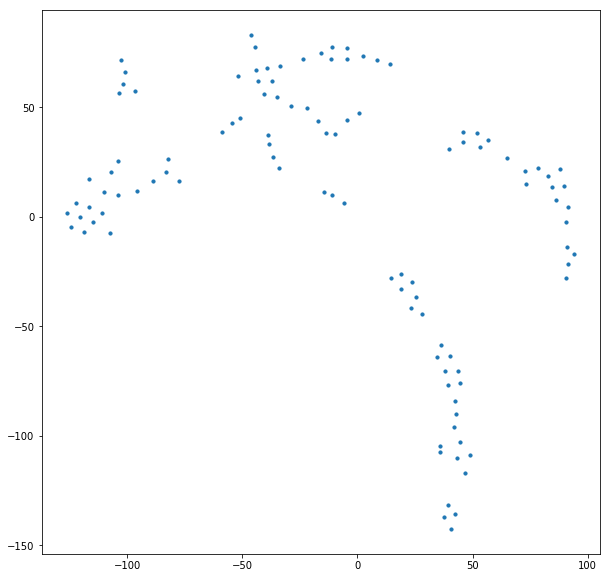

In [211]:
plt.figure(figsize = (10, 10))

plt.scatter(x = Y[:, 0], 
              y = Y[:, 1], 
              s = 10)

# for i in range(len(Y[:,0])):
#     plt.annotate(df_premiums.index[i][0:20], (Y[i,0], Y[i,1]))
    
plt.show()

## Test

In [157]:
fx = pd.read_excel('Wisselkoersen van de Gulden 1982-01 t_m 2001-12.xlsx', skiprows=3, index_col=1)
del fx['Unnamed: 0'] 
fx = fx.iloc[2:,]
fx.replace('           ',np.nan, inplace=True) # Remove cells with spaces
fx = fx.loc[~fx.index.duplicated(keep='first')]


In [158]:
fx.columns = pd.to_datetime(fx.columns)

In [210]:
fx

,1982-01-01 00:00:00,1982-02-01 00:00:00,1982-03-01 00:00:00,1982-04-01 00:00:00,1982-05-01 00:00:00,1982-06-01 00:00:00,1982-07-01 00:00:00,1982-08-01 00:00:00,1982-09-01 00:00:00,1982-10-01 00:00:00,...,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00
US dollar (1),2.5132,2.5957,2.6182,2.6623,2.5651,2.6860,2.7217,2.7274,2.7398,2.7582,...,2.42390,2.47080,2.52150,2.58310,2.56110,2.44790,2.41920,2.43300,2.48100,2.46960
Japanse yen (10.000),112.0100,110.2400,108.7300,109.0400,108.5300,106.9000,106.8700,105.4000,104.3300,101.8400,...,199.75000,199.73000,207.04000,211.36000,205.58000,201.55000,203.68000,200.61000,202.79000,194.43000
Valuta's in het eurogebied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belgische/Luxemburgse frank (100),6.4432,6.3276,5.9046,5.8783,5.8884,5.8146,5.7908,5.7514,5.6855,5.6229,...,5.46285,5.46285,5.46285,5.46285,5.46285,5.46285,5.46285,5.46285,5.46285,5.46285
Duitse mark (100),109.6100,109.6740,110.0290,110.9380,111.1070,110.5460,110.4580,110.0680,109.5230,109.0470,...,112.67400,112.67400,112.67400,112.67400,112.67400,112.67400,112.67400,112.67400,112.67400,112.67400
Griekse drachme (100),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.64670,0.64670,0.64670,0.64670,0.64670,0.64670,0.64670,0.64670,0.64670,0.64670
Spaanse peseta (100),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.32446,1.32446,1.32446,1.32446,1.32446,1.32446,1.32446,1.32446,1.32446,1.32446
Franse frank (100),43.1270,43.1320,42.6200,42.5870,42.6390,40.8760,39.7300,39.4080,38.7730,38.5780,...,33.59530,33.59530,33.59530,33.59530,33.59530,33.59530,33.59530,33.59530,33.59530,33.59530
Ierse pond (1),3.8719,3.8626,3.8562,3.8400,3.8429,3.8113,3.7996,3.7849,3.7515,3.7104,...,2.79813,2.79813,2.79813,2.79813,2.79813,2.79813,2.79813,2.79813,2.79813,2.79813
Italiaanse lire (10.000),20.4840,20.5170,20.2550,20.1690,20.0220,19.7830,19.7130,19.6210,19.4460,19.1910,...,11.38120,11.38120,11.38120,11.38120,11.38120,11.38120,11.38120,11.38120,11.38120,11.38120


In [175]:
usd = fx.loc['US dollar (1)',]

In [182]:
usd = pd.DataFrame(usd).reset_index()
usd.columns = ['ds','y']

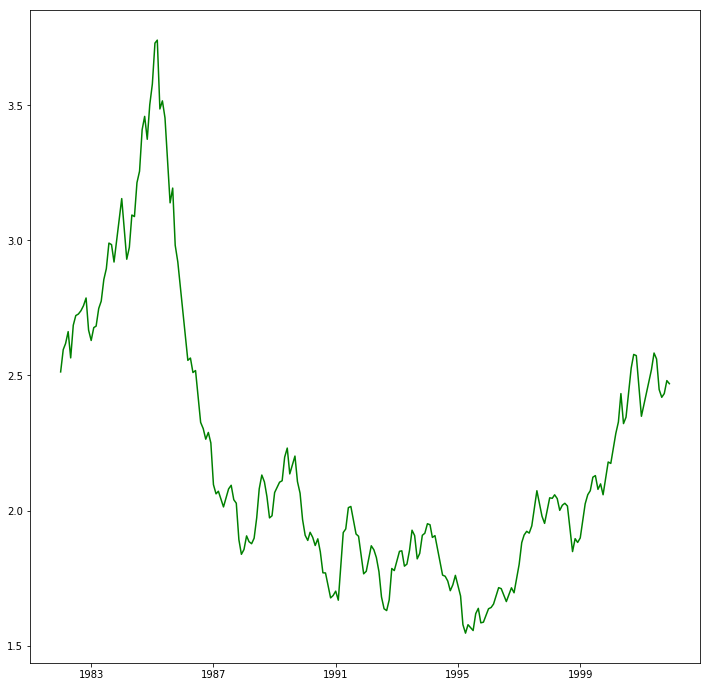

In [194]:
plt.plot(usd['ds'], usd['y'], c='green')
# plt.ylim([0,5])

In [190]:
m = Prophet()
m.fit(usd)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [198]:
future = m.make_future_dataframe(periods=730)
future.tail()

,ds
965,2003-11-27
966,2003-11-28
967,2003-11-29
968,2003-11-30
969,2003-12-01


In [199]:
forecast = m.predict(future)
forecast[['ds', 'yhat']].tail()

,ds,yhat
965,2003-11-27,2.808160
966,2003-11-28,2.799994
967,2003-11-29,2.789649
968,2003-11-30,2.777275
969,2003-12-01,2.763073


And plot our prediction.

In [201]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1982-01-01,2.637346,2.413356,2.808602,2.637346,2.637346,-0.018676,-0.018676,-0.018676,-0.018676,-0.018676,-0.018676,0.0,0.0,0.0,2.618670
1,1982-02-01,2.653746,2.462180,2.843647,2.653746,2.653746,0.003851,0.003851,0.003851,0.003851,0.003851,0.003851,0.0,0.0,0.0,2.657597
2,1982-03-01,2.668560,2.492139,2.874388,2.668560,2.668560,0.009807,0.009807,0.009807,0.009807,0.009807,0.009807,0.0,0.0,0.0,2.678366
3,1982-04-01,2.684960,2.504888,2.884681,2.684960,2.684960,0.008770,0.008770,0.008770,0.008770,0.008770,0.008770,0.0,0.0,0.0,2.693730
4,1982-05-01,2.700831,2.519092,2.887612,2.700831,2.700831,0.005805,0.005805,0.005805,0.005805,0.005805,0.005805,0.0,0.0,0.0,2.706636
5,1982-06-01,2.717232,2.562129,2.938025,2.717232,2.717232,0.036450,0.036450,0.036450,0.036450,0.036450,0.036450,0.0,0.0,0.0,2.753681
6,1982-07-01,2.733103,2.572617,2.952244,2.733103,2.733103,0.031809,0.031809,0.031809,0.031809,0.031809,0.031809,0.0,0.0,0.0,2.764912
7,1982-08-01,2.749503,2.578383,2.961069,2.749503,2.749503,0.025330,0.025330,0.025330,0.025330,0.025330,0.025330,0.0,0.0,0.0,2.774833
8,1982-09-01,2.765904,2.573678,2.977653,2.765904,2.765904,0.019811,0.019811,0.019811,0.019811,0.019811,0.019811,0.0,0.0,0.0,2.785715
9,1982-10-01,2.781775,2.568462,2.959134,2.781775,2.781775,-0.009434,-0.009434,-0.009434,-0.009434,-0.009434,-0.009434,0.0,0.0,0.0,2.772341


In [208]:
forecast.tail(100)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
870,2003-08-24,2.735800,2.401418,2.847492,2.633726,2.840312,-0.115437,-0.115437,-0.115437,-0.115437,-0.115437,-0.115437,0.0,0.0,0.0,2.620363
871,2003-08-25,2.736181,2.411608,2.853040,2.633797,2.841009,-0.094014,-0.094014,-0.094014,-0.094014,-0.094014,-0.094014,0.0,0.0,0.0,2.642168
872,2003-08-26,2.736563,2.444124,2.880785,2.633867,2.841706,-0.073019,-0.073019,-0.073019,-0.073019,-0.073019,-0.073019,0.0,0.0,0.0,2.663544
873,2003-08-27,2.736944,2.463357,2.904078,2.634169,2.842403,-0.052969,-0.052969,-0.052969,-0.052969,-0.052969,-0.052969,0.0,0.0,0.0,2.683976
874,2003-08-28,2.737326,2.481659,2.929533,2.634569,2.843100,-0.034345,-0.034345,-0.034345,-0.034345,-0.034345,-0.034345,0.0,0.0,0.0,2.702981
875,2003-08-29,2.737707,2.507442,2.943065,2.634970,2.843798,-0.017585,-0.017585,-0.017585,-0.017585,-0.017585,-0.017585,0.0,0.0,0.0,2.720122
876,2003-08-30,2.738089,2.504108,2.955260,2.635179,2.844495,-0.003075,-0.003075,-0.003075,-0.003075,-0.003075,-0.003075,0.0,0.0,0.0,2.735014
877,2003-08-31,2.738470,2.509864,2.971585,2.635263,2.845192,0.008868,0.008868,0.008868,0.008868,0.008868,0.008868,0.0,0.0,0.0,2.747338
878,2003-09-01,2.738852,2.542183,2.980746,2.635347,2.845889,0.017992,0.017992,0.017992,0.017992,0.017992,0.017992,0.0,0.0,0.0,2.756844
879,2003-09-02,2.739233,2.521810,2.984749,2.635430,2.846586,0.024126,0.024126,0.024126,0.024126,0.024126,0.024126,0.0,0.0,0.0,2.763359


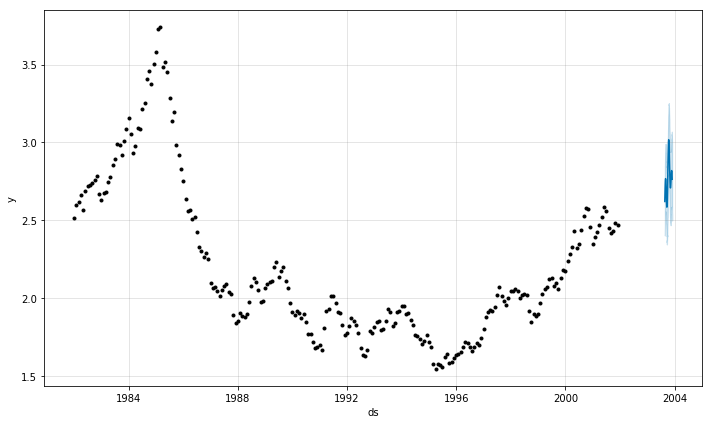

In [209]:
m.plot(forecast.tail(100))
plt.show()

# Glossary & References

* Euribor, or the Euro Interbank Offer Rate, is a reference rate that is constructed from the average interest rate at which eurozone banks offer unsecured short-term lending on the inter-bank market (https://www.investopedia.com/terms/e/euribor.asp).
* [Python Exercises](https://github.com/iitmcvg/Python-Exercises/)
* [Prophet: forecasting at scale](https://research.fb.com/prophet-forecasting-at-scale/)


